In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [3]:
!pip install torch-scatter torch-sparse torch-geometric torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 132.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 124.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.5 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

In [5]:
path = './qm9'
qm9 = QM9(path)

Extracting qm9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [6]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual att

In [7]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

In [8]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [9]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [18]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    # loss = torch.nn.MSELoss()
    loss = torch.nn.L1Loss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [11]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [12]:
# Training GIN for 10 epochs
epochs = 10
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.7112877368927002, Val loss: 0.5217502117156982
Epoch: 2, Train loss: 0.5345607399940491, Val loss: 0.4577274024486542
Epoch: 4, Train loss: 0.5022792816162109, Val loss: 0.4360872209072113
Epoch: 6, Train loss: 0.45836779475212097, Val loss: 0.4114389717578888
Epoch: 8, Train loss: 0.4332517087459564, Val loss: 0.40497344732284546


In [13]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [14]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

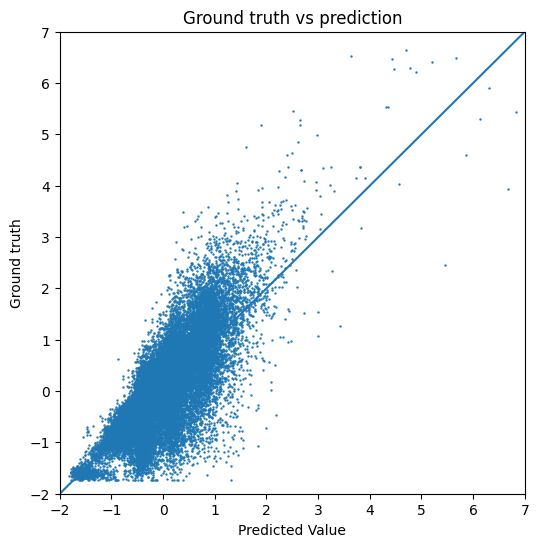

In [15]:
plot_targets(gin_train_target, gin_train_y_target)

Epoch: 0, Train loss: 0.7602908611297607, Val loss: 0.5551365613937378
Epoch: 2, Train loss: 0.5583057999610901, Val loss: 0.5226595997810364
Epoch: 4, Train loss: 0.5209110975265503, Val loss: 0.48194196820259094
Epoch: 6, Train loss: 0.4750748574733734, Val loss: 0.4302348494529724
Epoch: 8, Train loss: 0.4601733684539795, Val loss: 0.6316893696784973
Epoch: 10, Train loss: 0.43827468156814575, Val loss: 0.5306046605110168
Epoch: 12, Train loss: 0.4325393736362457, Val loss: 0.39051857590675354
Epoch: 14, Train loss: 0.4100229740142822, Val loss: 0.44595471024513245
Epoch: 16, Train loss: 0.4044911861419678, Val loss: 0.382292240858078
Epoch: 18, Train loss: 0.39970314502716064, Val loss: 0.3399603068828583
Epoch: 20, Train loss: 0.38439950346946716, Val loss: 0.35900354385375977
Epoch: 22, Train loss: 0.38527679443359375, Val loss: 0.3359961211681366
Epoch: 24, Train loss: 0.37241801619529724, Val loss: 0.3409210741519928
Epoch: 26, Train loss: 0.37125709652900696, Val loss: 0.32328

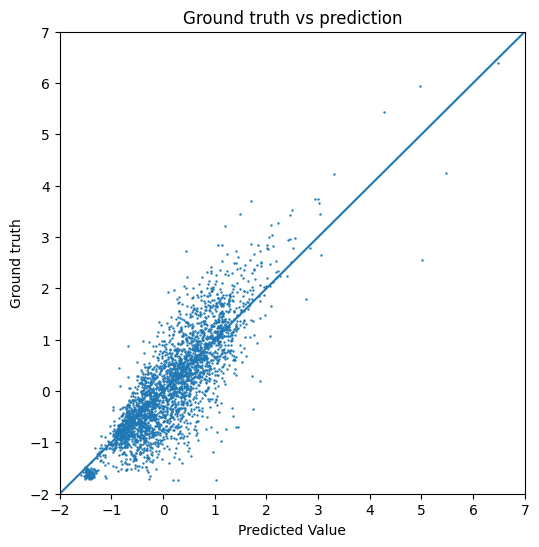

In [19]:
model = GIN(dim_h=64)
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    100, model, train_loader, test_loader, "GIN_model.pt"
)

Test Loss for GIN: 0.39729592204093933


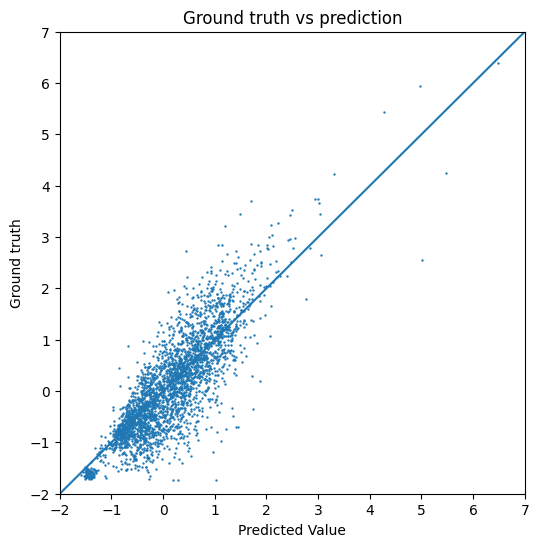

In [20]:
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

plot_targets(gin_test_target, gin_test_y)